<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/eigen_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EigenFaces: Face Recognition with Principal Component Analysis (PCA)

Face recognition is an important field in computer vision with numerous real-world applications, from unlocking your smartphone to enhancing security systems. Principal Component Analysis (PCA) is a powerful technique used to extract essential features from high-dimensional data.

In this notebook, we delve into the world of EigenFaces—a landmark approach in the realm of facial recognition. EigenFaces leverages PCA to represent faces as linear combinations of eigenfaces, which are the principal components of a training dataset. By using eigenfaces, we can reduce the dimensionality of facial data while retaining crucial information, allowing us to perform efficient and accurate face recognition.

**Limitations:**

- Eigenfaces performance decreases for recognition under different pose & lighting.
- Eigenfaces is very sensitive to scale, so a low-level pre-processing is vital for scale.
- Face images tested in the experiments are taken in the uniform background, while this situation is not suitable in natural scene


## Packages

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets

## 1. Load and Visualize Olivetti Faces Dataset

Load the Olivetti faces data-set from AT&T. The dataset contains :

- **Number of Identities**: 40
- **Number of Images**: 400
- **Image Size**: 64x64 pixels (flattened to 4096 features per image)
- **Pixel Normalization**: Values are normalized to [0, 1].

The dataset is structured as follows:

- The image dataset $X$ is represented as:

$$X=
\begin{bmatrix}
- & x_{1} & - \\
- & \dots  &- \\
- & x_{k} &-
\end{bmatrix} \in \mathbb{R}^{400 \times 4096}$$

- The target labels y are integers representing the identity of each face:

$$y =
\begin{bmatrix} y_{1} \\  \dots \\  y_{400}
\end{bmatrix} \in \mathbb{Z}^{400}$$

There are 40 unique faces
There are 400 faces
The single image size is (64, 64) 
The data range is [0.0,1.0]
X shape is (400, 4096)
y shape is (400,)


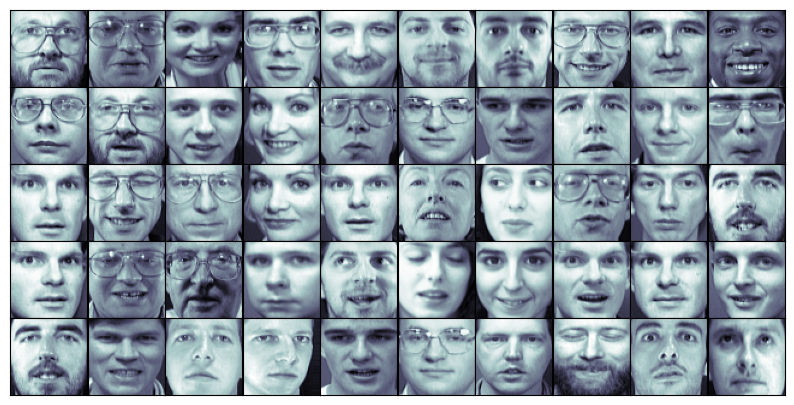

In [15]:
# Load dataset
bunch = datasets.fetch_olivetti_faces(return_X_y=False, shuffle=True)
X = bunch.data
y = bunch.target

NUM_EXAMPLES = X.shape[0]
NUM_UNIQUE_FACES = len(np.unique(y))
IMAGE_SHAPE = bunch.images.shape[1:]

# Print dataset informations
print("There are {} unique faces".format(NUM_UNIQUE_FACES))
print("There are {} faces".format(NUM_EXAMPLES))
print("The single image size is {} ".format(IMAGE_SHAPE))
print("The data range is [{},{}]".format(np.min(X), np.max(X)))
print("X shape is {}".format(X.shape))
print("y shape is {}".format(y.shape))

# Visualize few faces
def show_images(data_x):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        image = data_x[i].reshape(IMAGE_SHAPE)
        ax.imshow(image, cmap=plt.cm.bone)

show_images(X)

Lets visualize a specific identities

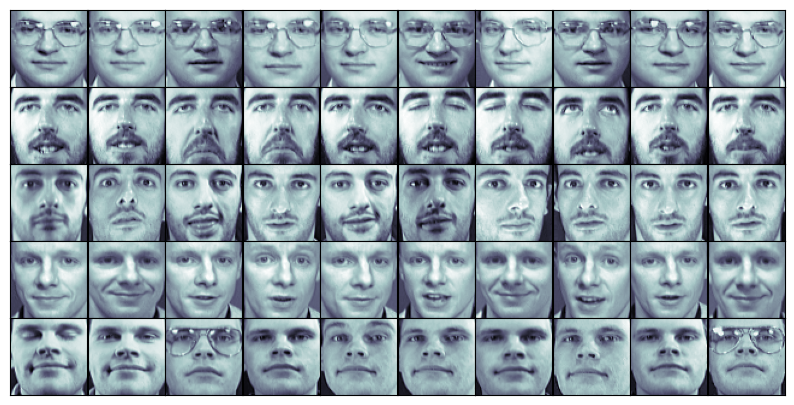

In [6]:
def show_identity(data_x, identities):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(wspace=0, hspace=0)
    i = 0
    for identity in identities:
        ids = np.argwhere(y == identity).flatten()
        for idx in range(10):
            ax = fig.add_subplot(len(identities), 10, i + 1, xticks=[], yticks=[])
            image = data_x[ids[idx]].reshape(IMAGE_SHAPE)
            ax.imshow(image, cmap=plt.cm.bone)
            i = i + 1
    plt.show()

show_identity(X, identities = [5, 10, 15, 20, 35])

## 2. Prepare dataset (Training & Test sets)

Let's generate the **Training Set** and **Test Set** fron $X$ and $y$,  as follows:

$$X = \begin{bmatrix}
X_{train}\\
\hline X_{test}
\end{bmatrix} \in \mathbb{R}^{40 \times 4096}, y = \begin{bmatrix}
y_{train}\\
\hline y_{test}
\end{bmatrix} \in \mathbb{Z}^{40}$$

**Training Set**

Let $M$ represent the number of training examples. The training set consists of:

$$X_{train}=
\begin{bmatrix}
- & x_{1} & - \\
- & \dots  &- \\
- & x_{m} &-
\end{bmatrix} \in \mathbb{R}^{m \times 4096}, y_{train} =
\begin{bmatrix} y_{1} \\  \dots \\  y_{m}
\end{bmatrix} \in \mathbb{Z}^{m}$$

**Test Set**

Let $N$ represent the number of test examples. The test set consists of:

$$X_{test}=
\begin{bmatrix}
- & x_{1} & - \\
- & \dots  &- \\
- & x_{n} &-
\end{bmatrix} \in \mathbb{R}^{n \times 4096}, y_{test} =
\begin{bmatrix} y_{1} \\  \dots \\  y_{n}
\end{bmatrix} \in \mathbb{Z}^{n}$$



In [8]:
from sklearn.model_selection import train_test_split

# Define split percentage
PERCENTAGE_TRAIN = 0.9

# Perform a stratified split to ensure all identities are represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 - PERCENTAGE_TRAIN, stratify=y, random_state=42
)

# Print information
NUM_UNIQUE_FACES = len(np.unique(y))
print("We are using {}% of the dataset for training".format(PERCENTAGE_TRAIN * 100))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("The y_train includes all the faces:", len(np.unique(y_train)) == NUM_UNIQUE_FACES)

We are using 90.0% of the dataset for training
X_train shape: (360, 4096)
y_train shape: (360,)
X_test shape: (40, 4096)
y_test shape: (40,)
The y_train includes all the faces: True


## 3. Training Stage

We are converting the images into a new space called the **face space**. The face space is computed using **Principal Component Analysis (PCA)**. The process involves the following steps: $ $


0. Preprocessing  (not implemented):
    - Ensure that the face images in $X$ are scaled and aligned correctly.
    - The backgrounds should be consistent or removed to focus solely on facial features.

1. Mean Centering:
    - Compute the average face $A$ from $X$
    - Subtract $A$ from each image in to center the data around the mean.

2. Compute Covariance Matrix
    - Calculate the covariance matrix $C$
    $$C=AA^{T} \in \mathbb{R}^{4096 \times 4096}$$

    where $A$ is the mean-centered data matrix.

3. Eigen Decomposition:
    - Determine the eigenvectors and eigenvalues of $C$.
    - The eigenvectors represent the principal components (or "eigenfaces"), which define the new coordinate system.


4. Project into Face Space:
    - Transform the original images into the **face space** by projecting them onto the principal components.


### 3.1 Mean Centering:

We center the data of $X_{train}$ into a new matrix $A$ by subtracting the **average face** $\Psi$.

**Compute the Average Face**

The average face $\Psi$ is calculated as:

$$\Psi = \frac{1}{M} \sum_{i=1}^{M} x_{i}$$

**Create the Mean-Centered Matrix $A$**

The mean-centered matrix $A$ is formed by subtracting $\Psi$ from each training sample:

$$A = \begin{bmatrix}
\vert & \vert & \vert \\
x_{1} - \Psi & \dots  & x_{m} - \Psi \\
\vert & \vert & \vert
\end{bmatrix} \in \mathbb{R}^{4096 \times m}$$




The size of MEAN is (4096,)
The size of A is (4096, 360)


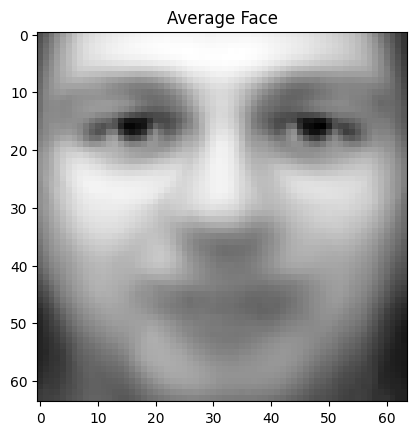

In [10]:
MEAN = np.mean(X_train, axis=0)
A = X_train.T
A = A - MEAN[:,np.newaxis]
print("The size of MEAN is {}".format(MEAN.shape))
print("The size of A is {}".format(A.shape))

ax = plt.subplot()
ax.set_title('Average Face')
image = MEAN.reshape(IMAGE_SHAPE)
img = ax.imshow(image)
img.set_cmap('gray')
plt.show()

### 3.2 & 3.3 Compute Covariance matrix and eigen vectors

The covariance matrix is defined as:

$$C=AA^{T}$$

Here, each column of $A$ contains one mean-centered, flattened image. The eigenvectors of the covariance matrix $C$ are known as eigenfaces. Eigenvalue decomposition is used to compute the eigenvectors and eigenvalues:

$$Cv_{i}=AA^{T}v_{i}=\lambda_{i}v_{i}$$

**Optimize Covariance Matrix**

However $C$ is a large matrix where $(4096 \gg m)$ , direct computation of its eigenvalues and eigenvectors is computationally expensive. For example, in the Olivetti Faces Dataset, with 400 examples of 64x64 images, the covariance matrix would have a size of $4096 \times 4906$.

**Turk and Pentland [2]** introduced a more efficient method to compute the eigenvalues and eigenvectors of *C* by focusing on a smaller matrix.

1. Consider the smaller matrix: Compute the matrix $A^{T}A \in \mathbb{R}^{m \times m} $

2. Compute eigenvectors: Determine the eigenvectors $u_i$ of $A^{T}A$ using:
$$A^{T}Au_{i}=\lambda_{i}u_{i}$$

3. Relate to the original covariance matrix: Using $v_{i}=Au_{i}$, substitute into the original covariance matrix $AA^{T}$ :
$$AA^{T}Au_{i}=\lambda_{i}Au_{i}$$
This shows that if  $u_{i}$  is an eigenvector of  $A^{T}A$, then $v_{i}=Au_{i}$ is an eigenvector of $AA^{T}$.

4. Compute and Normalize: Normalize $v_i$ to ensure unit length:
$$v_i = \frac{A u_i}{\| A u_i \|}$$

5. Form the Eigenfaces: Stack the $M$ best eigenvectors $v_{i}$ of $AA^{T}$ into matrix $Q$ , referred to as the **eigenfaces**.


The eigenfaces matrix $Q$ is defined as:

$$Q=\begin{bmatrix}
\vert & \vert & \vert \\
v_{1} & \dots & v_{n} \\
\vert & \vert & \vert
\end{bmatrix} \in \mathbb{R}^{4096 \times m}$$

eigen_faces shapes (4096, 360)


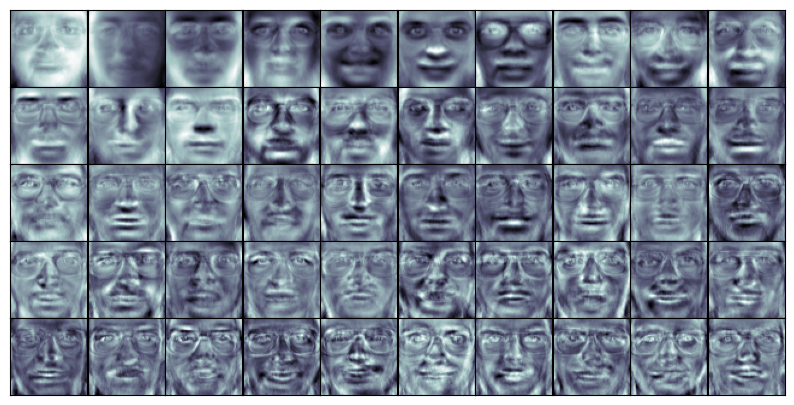

In [19]:
# Computes the eigen vectors
Cu = np.dot(A.T,A)
eigen_values, eigen_vectors = np.linalg.eig(Cu)
eigen_vectors = np.dot(A, eigen_vectors)

# Normalize eigenvectors - improve detection and reconstruction
inv_norms = 1.0 / np.linalg.norm(eigen_vectors, axis=0)
eigen_vectors = np.multiply(eigen_vectors, inv_norms)

# Sort the eigen vectors and eigen values
# The eigen faces are the eigen vectors
idx = eigen_values.argsort() # sort from low to high
idx = idx[::-1] #  reverse the order (from high to low)
eigen_values = eigen_values[idx]
Q = eigen_vectors[:,idx]

# Show Eigen Faces
print('eigen_faces shapes {}'.format(Q.shape))
show_images(Q.T)

### 3.4 Project into Face Space:

We compute the minimum components needed to retain 85% variance using cumulative eigenvalues.

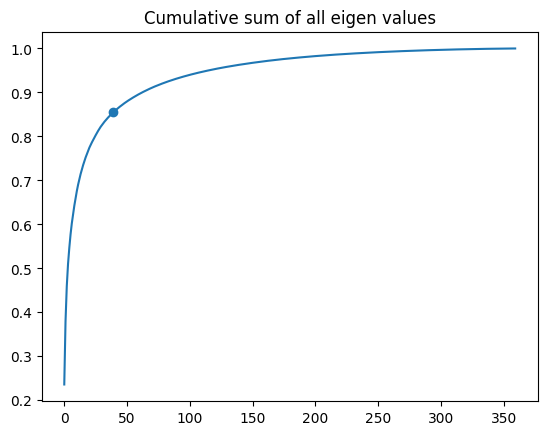

There are 39 components to keep 85% total variance


In [20]:
# Computes the number of principal components to keep 85% total variance
cumulative_values = np.cumsum(eigen_values) / np.sum(eigen_values)
num_components = 1
while cumulative_values[num_components-1] < 0.85:
    num_components += 1

ax = plt.subplot()
ax.scatter(num_components,cumulative_values[num_components])
ax.plot(cumulative_values)
plt.title('Cumulative sum of all eigen values')
plt.show()
print('There are {} components to keep 85% total variance'.format(num_components))

The eigenfaces $Q$ are reduced to $R$, retaining only the top $r$ eigenvectors corresponding to the largest eigenvalues:

$$R=\begin{bmatrix}
\vert & \vert & \vert \\
v_{1} & \dots & v_{r} \\
\vert & \vert & \vert
\end{bmatrix} \in \mathbb{R}^{4096 \times r}$$

The face weights $W$ are computed by projecting the input data $A$ onto the reduced face space $R$. $W$ is a compressed representation of the original dataset:

$$W = A^{T} R$$

$$W=
\begin{bmatrix}
- & w_{1} & - \\
- & \dots  &- \\
- & w_{m} &-
\end{bmatrix} \in \mathbb{R}^{M \times r}$$

Here:
- $M$: Number of training samples.
- $r$: Number of retained eigenvectors.


In [22]:
# Reduce the eigenfaces (Q)
R = Q[:,:num_components]
print("The size of the reduced eigen matrix is {}".format(R.shape))

# Project the image vector (stored in A) onto the eigen faces
W = np.dot(A.T, R)
print("The size of the face weights matrix is {}".format(W.shape))

The size of the reduced eigen matrix is (4096, 39)
The size of the face weights matrix is (360, 39)


## 4. Evaluate FaceSpace

Given the weight matrix W, the eigenfaces $Q$, and the mean face $\Psi$ , the reconstructed face is computed as:

$$\text{Reconstructed Face} = W_{\text{identity}, :k} \cdot Q_{:, :k}^T + \Psi$$

Where:

- $k$ :  The number of principal components used
- $W_{\text{identity}, :k}$ : The weights for the selected identity truncated $k$ components.
- $Q_{:, :k}$ : The top $k$ eigenfaces (principal components).

In [28]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(1, 2)
num_component_arrays = range(1, R.shape[1], 5)
def update_build_face_from_components(component_id):
  identity = 10
  num_components = num_component_arrays[component_id]
  face = np.dot(W[identity][:num_components], Q[:,:num_components].T)
  face = MEAN + face
  ax[0].set_title('Num component {}'.format(num_components))
  ax[0].imshow(face.reshape(IMAGE_SHAPE))
  ax[1].set_title('Input Data')
  ax[1].imshow((A[:,identity]+MEAN).reshape(IMAGE_SHAPE))

plt.set_cmap('gray')
plt.close()

anim = FuncAnimation(fig, update_build_face_from_components, frames=len(num_component_arrays), interval=40)
HTML(anim.to_jshtml())

##5. Facial recognition prediction


Load a single image from the test dataset and predict its identity ID. The test face is projected into the face space, and its weights are compared to those of the training data using Euclidean distance. The closest match (**the nearest neighbor**) is identified as the predicted identity.

While this approach uses the simplest nearest neighbor technique, other classifiers, such as **K-Nearest Neighbors**, **Decision Trees/Random Forests**, or **Support Vector Machines (SVMs)**, could be explored for more robust and accurate predictions in future implementations.

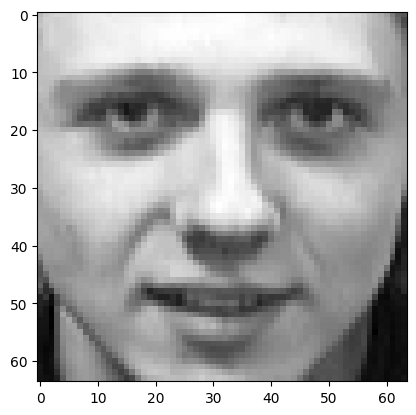

The Face ID is 11


In [33]:
IMAGE_TEST_INDEX = 10

def show_single_image(image_vector):
    ax = plt.subplot()
    image = image_vector.reshape(IMAGE_SHAPE)
    img = ax.imshow(image)
    img.set_cmap('gray')
    plt.show()

show_single_image(X_test[IMAGE_TEST_INDEX])
print("The Face ID is {}".format(y_test[IMAGE_TEST_INDEX]))

The input face id is 11
The predicted face is 11


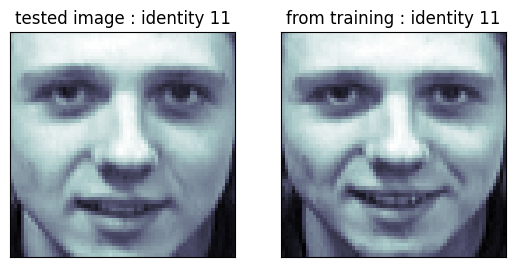

In [34]:
def predict_face_id(test_face_idx):
    # Compute the weights for the test face
    face_to_test = X_test[test_face_idx] - MEAN
    face_weight = np.dot(face_to_test.T, R)

    # Compute the euclidean distance between face_weight and face_weights
    euclidean_distance = np.linalg.norm(W - face_weight, axis=1)
    closest_face_index = np.argmin(euclidean_distance)
    return y_train[closest_face_index], closest_face_index

def show_prediction(test_face_idx, predicted_face_idx):
    fig = plt.figure()

    # test image
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    image = X_test[test_face_idx].reshape(IMAGE_SHAPE)
    ax.set_title('tested image : identity {}'.format(y_test[test_face_idx]))
    ax.imshow(image, cmap=plt.cm.bone)
    # predicted image from the train data
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('from training : identity {}'.format(y_train[predicted_face_idx]))
    image = X_train[predicted_face_idx].reshape(IMAGE_SHAPE)
    ax.imshow(image, cmap=plt.cm.bone)

print("The input face id is {}".format(y_test[IMAGE_TEST_INDEX]))
predicted, nearest_face_idx = predict_face_id(IMAGE_TEST_INDEX)
print("The predicted face is {}".format(predicted))
show_prediction(IMAGE_TEST_INDEX, nearest_face_idx)

## 6. Evaluate Model

Now, we evaluate the model on the entire test dataset. The evaluation includes:

- Confusion Matrix and Accuracy Score: To measure the model's overall performance.
- Visualization of Correct Predictions: Display examples where the model correctly identified the face.
- Visualization of Incorrect Predictions: Highlight examples where the model made incorrect predictions.


Accuracy score : 0.975


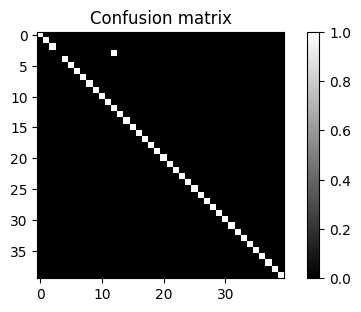

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

num_test_examples = X_test.shape[0]

y_true = [-1]*num_test_examples
y_pred = [-1]*num_test_examples
y_closest = [-1]*num_test_examples
for i in range(num_test_examples):
    y_true[i] = y_test[i]
    y_pred[i], y_closest[i] = predict_face_id(i)

print("Accuracy score : {}".format(accuracy_score(y_true, y_pred)))

fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('Confusion matrix')
plt.imshow(confusion_matrix(y_true, y_pred, normalize='true'))
ax.set_aspect('equal')
plt.colorbar(orientation='vertical')

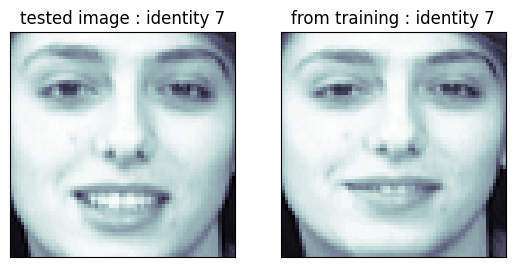

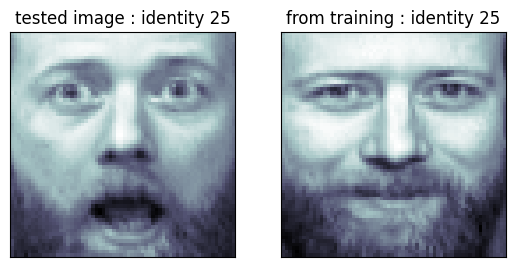

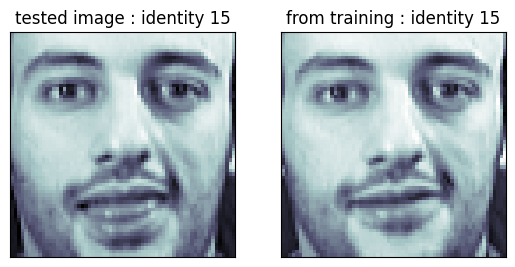

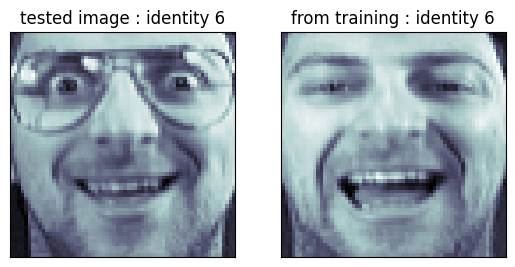

In [38]:
# visualize faces with a correct prediction
truth_array = np.asarray(y_true) == np.asarray(y_pred)
correct_match = np.argwhere(truth_array == True).flatten()
for i in correct_match[:4]:
    show_prediction(i, y_closest[i])

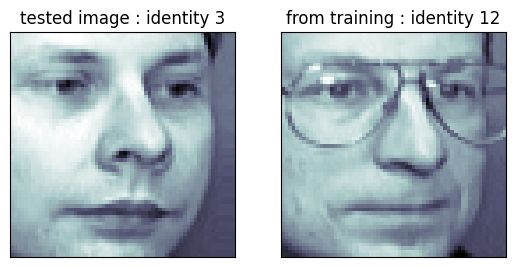

In [39]:
# visualize faces with a incorrect match
incorrect_match = np.argwhere(truth_array == False).flatten()
for i in incorrect_match[:4]:
    show_prediction(i, y_closest[i])

## References

- [1] Sirovich, Lawrence, and Michael Kirby. "Low-dimensional procedure for the characterization of human faces." Josa a 4, no. 3 (1987): 519-524.
- [2] Turk, Matthew A., and Alex P. Pentland. "Face recognition using eigenfaces." In Proceedings. 1991 IEEE computer society conference on computer vision and pattern recognition, pp. 586-587. IEEE Computer Society, 1991.
- [3] üge Çarıkçı, M., and Figen Özen. "A face recognition system based on eigenfaces method." Procedia Technology 1 (2012): 118-123.
- [4] http://www.scholarpedia.org/article/Eigenfaces
- [5] Images from AT&T Laboratories Cambridge.
https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html